In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import re
import primo.tools.filepath as filepaths

## Get guide sequence that we'll order from IDT


In [2]:
query_sequence_save_path = filepaths.get_encoded_query_sequences_path(isDocker=True)
query_seqs = pd.HDFStore(query_sequence_save_path, 'r')['/df']


In [3]:
query_seqs

,FeatureSequence
callie_janelle,ATGTCAGACGCTAAAATGAA
luis_lego,ATGTCAGACGCTAAAATGAA
yuan_taipei,AAGCCAAACGCCAAAATGAA


## Get target sequences that we'll order from Twist

In [6]:
sequence_store_path = filepaths.get_sequence_store_path(isDocker=True)
target_seqs = pd.HDFStore(sequence_store_path, 'r')['/df']


In [7]:
target_seqs

,FeatureSequence
000002b66c9c498e,ATCACAAACGCTGAAATGAA
000002b97e5471a0,AAGCCAAACGCCAAAATGAA
000002c707c9895e,ATGTCAGACGCTAAAATGAA
0000048549557964,AAGCCAAACGCCAAAATGAA
000004f4400f6ec5,AGCACAAACGCTGAAATGAA
...,...
ffffd9716fd38279,ACACCAAACGCCAAAATGAA
ffffda81903d6bb7,AGCGCAAACGCTGAAATGAA
ffffeac7d2f37489,AAGCCAAACGCCAAAATGAA
ffffebddbb8bba21,ATATCAGACGCTAAAATGAA


In [81]:
# Get all the unique Feature Sequences

unique_targets = target_seqs['FeatureSequence'].unique()
print('Total number of unique sequences:', len(unique_targets), '\n')


Total number of unique sequences: 353 



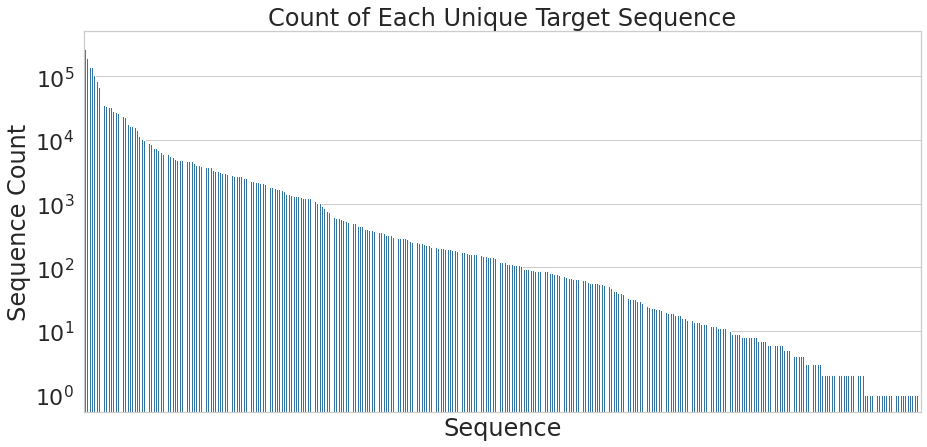

In [98]:
# Plot the number of times each sequence appears
# note- the breaks between clusters is an artifact, NOT a problem
sns.set(font_scale=2)
sns.set_style('whitegrid')
occur = target_seqs['FeatureSequence'].value_counts()
f, ax = plt.subplots(1, 1, figsize=(15,7))
g = sns.barplot(x=occur.index, y=occur, color='tab:blue')
g.set(xlabel='Sequence')
g.set(ylabel='Sequence Count')
ax.set_xticks([]) #g.set doesn't work
g.set(title="Count of Each Unique Target Sequence")
plt.yscale('log')
plt.savefig('unique_seq_counts.png', dpi=500)
plt.show()

## Get sequences in order-ready format
Sequence architecture is:

front_universal_primer | target_seq | PAM | file_ID | back_universal_primer

In [183]:
front_up = 'TACTCGCTGCGTGCAATTTA'
back_up =  'AAAGTGTCCGAACGTGTCAA'
PAM = 'TGG'

In [163]:
# generating file_ids

def edit_distance(str1, str2):
    """
    Given two strings, returns an integer that is the number of 
    different bases between the two strings.
    """
    # get length of strings and make sure they match!
    if len(str1) != len(str2):
        raise ValueError("Sequences should be the same length!")
    
    # tally number of different bases
    edit_dist = 0
    for i in range(len(str1)):
        if str1[i] != str2[i]:
            edit_dist += 1 
    return edit_dist

def passes_homopolymer_test(seq):
    """
    Given a DNA sequence (str), 
    Returns TRUE if the sequence does not have homopolymers > 3 in length, 
    Returns FALSE if the sequence DOES have homopolymers > 3 in length.
    """
    x = [(m.group(), m.start()) for m in re.finditer(r'([ACGT])\1{2,}', seq) if len(m.group()) > 3]
    if len(x) < 1:
        return True
    else:
        return False
    
def passes_edit_dist_test(id_list, id_seq, dist_threshold):
    """
    Given:
      id_list - a list of sequences (str) 
      id_seq - one individual sequence (str)
      dist_threshold - the minimum edit distance allowed between seqs (int)
    Returns TRUE if the edit distance between all sequences in the list and the id_seq
    is greater than or equal to the dist_threshold
    """
    for s in id_list:
        if edit_distance(s, id_seq) < dist_threshold:
            return False
    return True

def make_file_ids(num_ids, id_len):
    """
    Given:
      num_ids - the number of IDs you'd like to generate (int)
      id_len - the length each ID should be (int)
      dist_threshold - the minimum edit distance you want between all sequences
    Returns:
      id_list - list of DNA sequences that have all have a minimum edit
                distance from each other of dist_threshold, and homopolymers 
                no longer than 3
    """
    id_list = []
    dist_threshold = 11
    
    while len(id_list) < num_ids:
        id_seq = ''.join(np.random.choice(('C','G','T','A'), id_len))
        if passes_homopolymer_test(id_seq) and passes_edit_dist_test(id_list, id_seq, dist_threshold):
            id_list.append(id_seq)
    return id_list
       
file_id_list = make_file_ids(num_ids=len(unique_targets), id_len=20)

In [179]:
# add sequence ID to the target_seq dataframe as an ID column
id_dict = {}
count = 0
for s in unique_targets:
    id_dict[s] = file_id_list[count]
    count += 1
target_seqs['ID'] = target_seqs['FeatureSequence'].map(id_dict)   

In [185]:
# add oligo sequence to target_seq dataframe
target_seqs = target_seqs.assign(Oligo = 
                                 lambda x: 
                                 (front_up + ' ' + x['FeatureSequence'] + ' ' + PAM + ' ' + 
                                 x['ID'] + ' ' + back_up))

In [190]:
target_seqs['Oligo'][1743040]

'TACTCGCTGCGTGCAATTTA ATATCAGACGCTAAAATGAA TGG TTAACAACGGCTCTCGGCCC AAAGTGTCCGAACGTGTCAA'

In [189]:
target_seqs

,FeatureSequence,ID,Oligo
000002b66c9c498e,ATCACAAACGCTGAAATGAA,ATTTCACCCAGATCGGGCGC,TACTCGCTGCGTGCAATTTA ATCACAAACGCTGAAATGAA TGG ...
000002b97e5471a0,AAGCCAAACGCCAAAATGAA,AATAAGGGCCTTATAGGTAG,TACTCGCTGCGTGCAATTTA AAGCCAAACGCCAAAATGAA TGG ...
000002c707c9895e,ATGTCAGACGCTAAAATGAA,ATGCGGCTCACGTTGATCCG,TACTCGCTGCGTGCAATTTA ATGTCAGACGCTAAAATGAA TGG ...
0000048549557964,AAGCCAAACGCCAAAATGAA,AATAAGGGCCTTATAGGTAG,TACTCGCTGCGTGCAATTTA AAGCCAAACGCCAAAATGAA TGG ...
000004f4400f6ec5,AGCACAAACGCTGAAATGAA,GTAACTGCGCCAGTCTCAAG,TACTCGCTGCGTGCAATTTA AGCACAAACGCTGAAATGAA TGG ...
...,...,...,...
ffffd9716fd38279,ACACCAAACGCCAAAATGAA,ATTAGCTCTAATGCAAGACA,TACTCGCTGCGTGCAATTTA ACACCAAACGCCAAAATGAA TGG ...
ffffda81903d6bb7,AGCGCAAACGCTGAAATGAA,AGTTCATGACCAGTCGGTTG,TACTCGCTGCGTGCAATTTA AGCGCAAACGCTGAAATGAA TGG ...
ffffeac7d2f37489,AAGCCAAACGCCAAAATGAA,AATAAGGGCCTTATAGGTAG,TACTCGCTGCGTGCAATTTA AAGCCAAACGCCAAAATGAA TGG ...
ffffebddbb8bba21,ATATCAGACGCTAAAATGAA,TTAACAACGGCTCTCGGCCC,TACTCGCTGCGTGCAATTTA ATATCAGACGCTAAAATGAA TGG ...


In [192]:
# save
path = "/tf/primo/data/targets/seqs_to_order.h5"
seq_store = pd.HDFStore(path, complevel=9, mode='w')
seq_store.close()

In [195]:
target_seqs['Oligo'].unique()

array(['TACTCGCTGCGTGCAATTTA ATCACAAACGCTGAAATGAA TGG ATTTCACCCAGATCGGGCGC AAAGTGTCCGAACGTGTCAA',
       'TACTCGCTGCGTGCAATTTA AAGCCAAACGCCAAAATGAA TGG AATAAGGGCCTTATAGGTAG AAAGTGTCCGAACGTGTCAA',
       'TACTCGCTGCGTGCAATTTA ATGTCAGACGCTAAAATGAA TGG ATGCGGCTCACGTTGATCCG AAAGTGTCCGAACGTGTCAA',
       'TACTCGCTGCGTGCAATTTA AGCACAAACGCTGAAATGAA TGG GTAACTGCGCCAGTCTCAAG AAAGTGTCCGAACGTGTCAA',
       'TACTCGCTGCGTGCAATTTA ACACCAAACGCCAAAATGAA TGG ATTAGCTCTAATGCAAGACA AAAGTGTCCGAACGTGTCAA',
       'TACTCGCTGCGTGCAATTTA ACTGCAGACGCCAAAATGAA TGG AATACTCGAGAAGCATCAGA AAAGTGTCCGAACGTGTCAA',
       'TACTCGCTGCGTGCAATTTA ACGCCAAACGCCAAAATGAA TGG AGAAACCACTCTCCTGTCCC AAAGTGTCCGAACGTGTCAA',
       'TACTCGCTGCGTGCAATTTA AGTGCAGACGCCGAAATGAA TGG CGTAAAGCTGCCAGGGCTCG AAAGTGTCCGAACGTGTCAA',
       'TACTCGCTGCGTGCAATTTA AGTGCAAACGCCGAAATGAA TGG CTTAAATTACAGGAGTTTCG AAAGTGTCCGAACGTGTCAA',
       'TACTCGCTGCGTGCAATTTA ACTCCAAACGCCAAAATGAA TGG AGGTAATTGAGGAGGCTTGC AAAGTGTCCGAACGTGTCAA',
       'TACTCGCTGCGT

In [197]:
import csv

yourArray = target_seqs['Oligo'].unique()
yourArray = np.array(yourArray)

with open('/tf/primo/data/targets/oligo_order.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in range(0,yourArray.shape[0]):
        myList = []
        myList.append(yourArray[row])
        writer.writerow(myList)